# Scraper
-----
- Extracts data from weather balloon readings
- Transforms data into standard format
- Displays data on easily understandable graphs

In [51]:
import requests
import pandas as pd
from datetime import date, datetime, timedelta
from bs4 import BeautifulSoup
import numpy as np
from math import floor
from pathlib import Path  
from alive_progress import alive_bar
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns

### Define baseline params
- URL to be used
- Columns to be extracted
- Weather stations to examine
- Current date/time

In [27]:
base_url = "http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST"

cols = ["Date", 
        "Station", 
        "Pressure", 
        "Height", 
        "Temp", 
        "DewPoint", 
        "Relative_Humidity", 
        "Mean_Mixed_Layer", 
        "Wind_Direction", 
        "Wind_Speed", 
        "Potential_Temp",
        "Equivalent_Potential_Temp",
        "Virtual_Potential_Temp"]

stations = [
    {"id": 72797, "name": "Quillayute"},
    {"id": 73033, "name": "Vernon"},
    {"id": 71109, "name": "Port Hardy"}]

now = [
    datetime.now().year, 
    datetime.now().month, 
    datetime.now().day]

## Define date range function
---
- Accept start and end date
- Return range of dates between start and end

In [28]:
# Creates date range from str format dates
# e.g. "2021-01-01"
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

## Create list of URLs to scrape
---
- Iterate throguh date ranges
- Iterate through stations
- Return list of all URLs to be scraped

In [81]:
# Create date range
# ~~~~~~~~~~~~~~~~~
dates_arr = []
start_date = date(2022, 10, 1)
#start_date = date(now[0], now[1], now[2])
end_date = date(now[0], now[1], now[2]+1)
print(f"Start Date:\t{start_date}\nEnd Date:\t{end_date}")

for single_date in daterange(start_date, end_date):
    single_date = (str(single_date).split("-")) 
    dates_arr.append([ int(x) for x in single_date ])
       
# Create list of URLs for each station
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
urls = []
dates_idx = []
station_idx = []
for d in dates_arr:
    for station in stations:
        url = base_url
        url += "&YEAR={}".format(d[0])
        url += "&MONTH={}".format(d[1])
        #url += "&FROM=" + str(now[1]) + str(now[2])
        #url += "&TO=" + str(now[1]) + str(now[2])
        url += "&FROM={:0>2d}12".format(d[2])
        url += "&TO={:0>2d}12".format(d[2])
        url += "&STNM={}".format(station["id"])
        url += "&REPLOT=1"
        urls.append(url)
        
        
        dates_idx.append("%02d-%02d-%02d" % (d[0], d[1], d[2]))
        station_idx.append(station["name"])

print(urls[0])
for url in urls:
    print(url)

Start Date:	2022-10-01
End Date:	2022-12-07
http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2022&MONTH=10&FROM=0112&TO=0112&STNM=72797&REPLOT=1
http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2022&MONTH=10&FROM=0112&TO=0112&STNM=72797&REPLOT=1
http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2022&MONTH=10&FROM=0112&TO=0112&STNM=73033&REPLOT=1
http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2022&MONTH=10&FROM=0112&TO=0112&STNM=71109&REPLOT=1
http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2022&MONTH=10&FROM=0212&TO=0212&STNM=72797&REPLOT=1
http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2022&MONTH=10&FROM=0212&TO=0212&STNM=73033&REPLOT=1
http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2022&MONTH=10&FROM=0212&TO=0212&STNM=71109&REPLOT=1
http://weather.uwyo.edu/cgi-bin/sounding?region=nacon

## Extract data from list of URLs
---
- Iterate through URLs
- Extract 700 and 850 data items
- Append data to array

In [82]:
data = []
reading_idx = []


print("Extracting data from URLs: ")
with alive_bar(len(urls), force_tty=True) as bar:
    for i, url in enumerate(urls):
        
        # scrape site data
        # ~~~~~~~~~~~~~~~~
        page = requests.get(url)
        soup = BeautifulSoup(page.content, "html.parser")
        results = str(soup.find('pre'))

        # we want 700 first // 850 second
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        data.append(results[results.find("700"):].split()[:11])
        data[-1].insert(0, dates_idx[i])
        data[-1].insert(1, station_idx[i])
        data.append(results[results.find("850"):].split()[:11])
        data[-1].insert(0, dates_idx[i])
        data[-1].insert(1, station_idx[i])
        
        bar()
        

print("\nComplete")


Extracting data from URLs: 
|████████████████████████████████████████| 201/201 [100%] in 6:41.4 (0.50/s)                                            

Complete


## Clean Data
---
- Remove unwanted chars from fields
- Convert wind speed to km/h from knots

In [88]:
# Remove rogue "e" values from pressure field
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
pressures = [700, 850]
ctr = 0
for item in data:
    if(not str(item[2]).isnumeric()):
        item[2] = pressures[ctr%2]
    ctr += 1

In [91]:
df = pd.DataFrame(data, columns=cols)

# Convert DataFrame to numeric values
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for col in cols[2:]:
    try:
        df[col] = pd.to_numeric(df[col])
    except:
        print(col)
    
# Convert wind speed from Knots to KM/H
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
df['Wind_Speed'] = df['Wind_Speed'].multiply(1.852)
df.head()

,Date,Station,Pressure,Height,Temp,DewPoint,Relative_Humidity,Mean_Mixed_Layer,Wind_Direction,Wind_Speed,Potential_Temp,Equivalent_Potential_Temp,Virtual_Potential_Temp
0,2022-10-01,Quillayute,700,3156.0,5.6,-5.4,45.0,3.67,45.0,20.372,308.6,320.4,309.3
1,2022-10-01,Quillayute,850,1541.0,14.4,5.4,55.0,6.66,155.0,12.964,301.2,321.3,302.4
2,2022-10-01,Vernon,700,3153.0,3.2,-3.8,60.0,4.14,200.0,14.816,306.0,319.0,306.8
3,2022-10-01,Vernon,850,1545.0,12.4,7.4,72.0,7.65,60.0,9.260,299.1,321.9,300.5
4,2022-10-01,Port Hardy,700,3174.0,5.2,-4.8,48.0,3.84,260.0,16.668,308.2,320.5,308.9


In [92]:
df.tail()

,Date,Station,Pressure,Height,Temp,DewPoint,Relative_Humidity,Mean_Mixed_Layer,Wind_Direction,Wind_Speed,Potential_Temp,Equivalent_Potential_Temp,Virtual_Potential_Temp
397,2022-12-06,Quillayute,850,1455.0,-4.7,-5.1,97.0,3.09,260.0,25.928,281.2,290.1,281.7
398,2022-12-06,Vernon,700,2897.0,-11.7,-13.6,86.0,1.92,300.0,64.820,289.5,295.4,289.8
399,2022-12-06,Vernon,850,1395.0,-8.3,-10.0,88.0,2.11,220.0,38.892,277.4,283.6,277.8
400,2022-12-06,Port Hardy,700,2969.0,-7.3,-14.3,57.0,1.81,310.0,53.708,294.4,300.1,294.7
401,2022-12-06,Port Hardy,850,1430.0,-4.7,-6.5,87.0,2.78,260.0,25.928,281.2,289.2,281.7


## Export data to CSV
---
Create new file for each date the extraction is run and save to /data/ folder

In [93]:
filepath = Path('./data/raw_scrape-{}-{}-{}.csv'.format(datetime.now().year, datetime.now().month, datetime.now().day))  
filepath.parent.mkdir(parents=True, exist_ok=True) 
df.to_csv(filepath)

### Split Data by Region
---
Seperate the general DataFrame for simpler manipulation

In [158]:
df.set_index(['Date','Station','Pressure'])
labels=['Vernon 700', 'Vernon 850', 'Quillayute 700', 'Quillayute 850', 'Port Hardy 700', 'Port Hardy 850']

## Plot Data
---

In [164]:
df[pd.isnull(df.Temp)]

,Date,Station,Pressure,Height,Temp,DewPoint,Relative_Humidity,Mean_Mixed_Layer,Wind_Direction,Wind_Speed,Potential_Temp,Equivalent_Potential_Temp,Virtual_Potential_Temp
36,2022-10-07,Quillayute,700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,2022-10-07,Quillayute,850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,2022-10-08,Quillayute,700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,2022-10-08,Quillayute,850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,2022-10-08,Vernon,850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
236,2022-11-09,Vernon,700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
237,2022-11-09,Vernon,850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
244,2022-11-10,Port Hardy,700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2022-11-10,Port Hardy,850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2022-11-11,Quillayute,700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


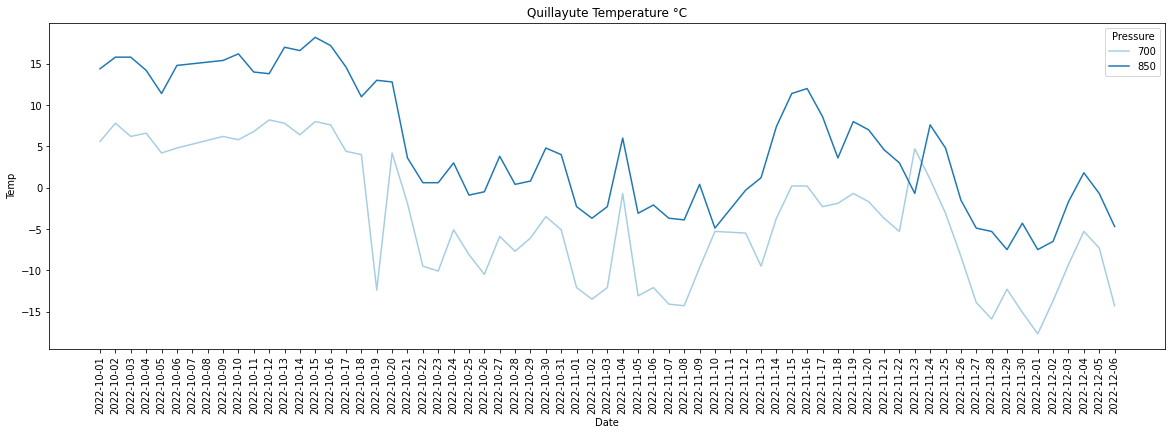

In [159]:
# Set the width and height of the figure
plt.figure(figsize=(20,6))

# Add title
plt.title("Quillayute Temperature °C")

# Line chart showing daily temps of Quillayute weather balloon at both 700 and 850 hPa
palette = sns.color_palette("Paired", n_colors=6)
sns.lineplot(x='Date', y='Temp', hue='Pressure', data=df[df['Station'] == "Quillayute"], palette=palette[0:2])

# Display x labels vertically
plt.xticks(rotation = 'vertical')

plt.show()

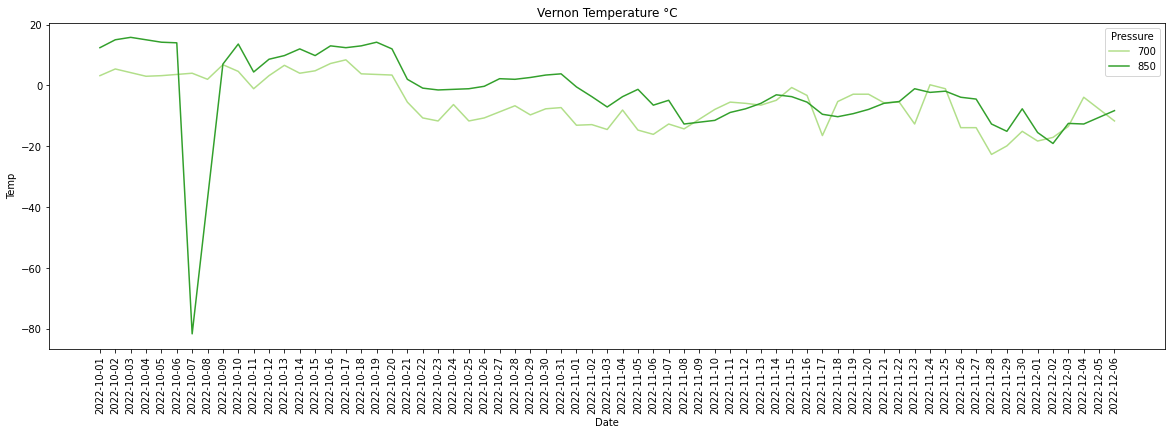

In [160]:
# Set the width and height of the figure
plt.figure(figsize=(20,6))

# Add title
plt.title("Vernon Temperature °C")

# Line chart showing daily temps of Quillayute weather balloon at both 700 and 850 hPa
palette = sns.color_palette("Paired", n_colors=6)
sns.lineplot(x='Date', y='Temp', hue='Pressure', data=df[df['Station'] == "Vernon"], palette=palette[2:4])

# Display x labels vertically
plt.xticks(rotation = 'vertical')

plt.show()

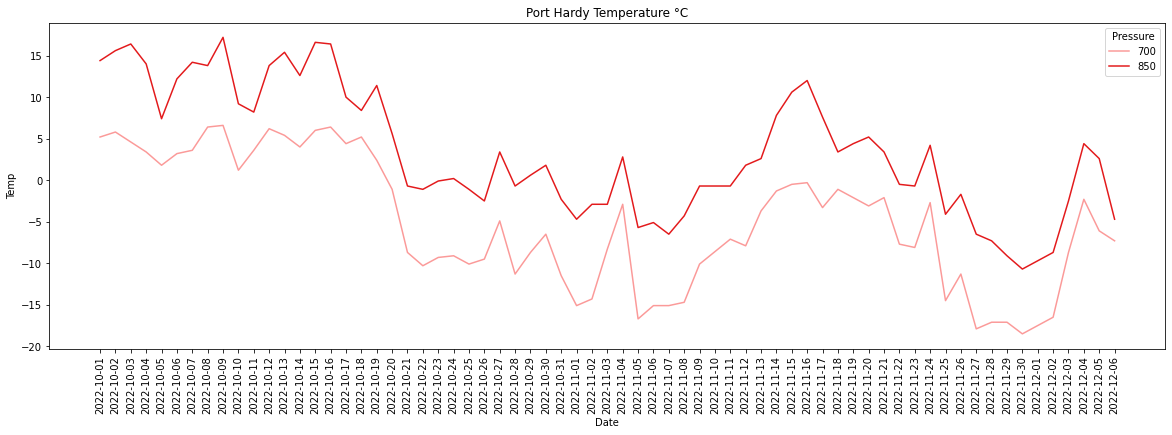

In [161]:
# Set the width and height of the figure
plt.figure(figsize=(20,6))

# Add title
plt.title("Port Hardy Temperature °C")

# Line chart showing daily temps of Quillayute weather balloon at both 700 and 850 hPa
palette = sns.color_palette("Paired", n_colors=6)
sns.lineplot(x='Date', y='Temp', hue='Pressure', data=df[df['Station'] == "Port Hardy"], palette=palette[4:6])

# Display x labels vertically
plt.xticks(rotation = 'vertical')
plt.show()

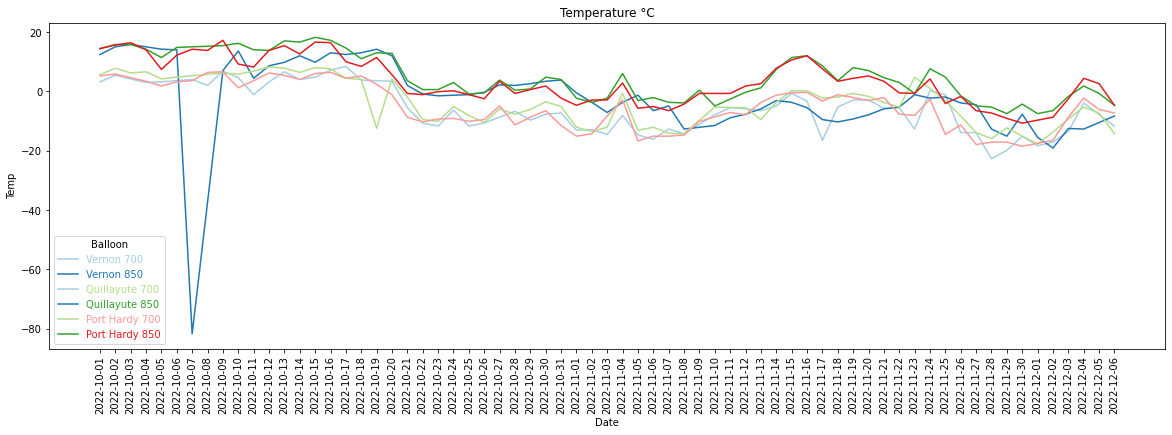

In [162]:
# Set up the figure
plt.figure(figsize=(20,6))
plt.title("Temperature °C")
plt.xticks(rotation = 'vertical')

# Line chart showing daily temps of Each Station's weather balloon at both 700 and 850 hPa
palette = sns.color_palette("Paired", n_colors=6)
sns.lineplot(x='Date', y='Temp', hue='Pressure', data=df[df['Station'] == "Vernon"], palette=palette[0:2])
sns.lineplot(x='Date', y='Temp', hue='Pressure', data=df[df['Station'] == "Quillayute"], palette=palette[2:4])
sns.lineplot(x='Date', y='Temp', hue='Pressure', data=df[df['Station'] == "Port Hardy"], palette=palette[4:6])

plt.legend(title='Balloon', labels=labels, labelcolor=palette)

plt.show()

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
#  ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ NOTES ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

## APP (2)

Easy to read / on the go / big text

700 | 3020m | -7 |
- - - - - - - - -
850 | 1590m | -9 |

Wind direction in an arrow // color coded magnitude and direction


Gathering data from brohm ridge needs to be done hourly
- looking like avalanche canada page on Wx


## Drive (1)
Guide daily forms
- Integrate to slack

Users need to see
- Just the weather info


## Webcms (3)
(load one by one -- javascript)
- cayoosh
- whistler peak
- blackcomb
- rubble creek
- brohm ridge
- s2s


western developement fund of canada /// Western Economic Diversification Canada

In [ ]:
table = [dates]
dates = [locations]
location = [variables]